# Some very simple GMIP3 data example use cases

- [1. I want to get the glacier model simulations from an individual glacier model for a specific period and compare it with my study/model](#1.-I-want-to-get-the-glacier-model-simulations-from-the-individual-glacier-models-and-compare-it-with-my-study-...)
- [2. I want to analyse the relationship of steady-state mass changes of a glacier model to global warming for a specific region](#2.-I-want-to-analyse-the-relationship-of-steady-state-mass-changes-of-a-glacier-model-to-global-warming-for-a-specific-region) 
- [3. I want to extract LOWESS fitted steady-state glacier mass estimates](#3.-I-want-to-extract-LOWESS-fitted-steady-state-glacier-mass-estimates)
- [4. Ask us to get more use case examples! -> contact](mailto:lilian.schuster@uibk.ac.at,harry.zekollari@vub.be)
 
--> all code for the first GlacierMIP3 manuscript analysis and creation of the figures is available at: [https://github.com/GlacierMIP/GlacierMIP3](https://github.com/GlacierMIP/GlacierMIP3)

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

<a id='q1'></a>
## 1. I want to get the glacier model simulations from the individual glacier models and compare it with my study ...
</a> 

In [2]:
ds = xr.open_dataset('GMIP3_reg_glacier_model_data/glacierMIP3_Feb12_2024_models_all_rgi_regions_sum.nc')

In [3]:
# let's look into how the data looks like
ds

<xarray.Dataset>
Dimensions:          (model_author: 10, simulation_year: 5001, gcm: 5,
                      rgi_reg: 19, period_scenario: 16)
Coordinates:
  * model_author     (model_author) <U14 'CISM2' 'GO' ... 'GloGEMflow3D'
  * simulation_year  (simulation_year) int16 0 1 2 3 4 ... 4997 4998 4999 5000
  * gcm              (gcm) <U13 'gfdl-esm4' 'ipsl-cm6a-lr' ... 'ukesm1-0-ll'
  * rgi_reg          (rgi_reg) <U2 '01' '02' '03' '04' ... '16' '17' '18' '19'
  * period_scenario  (period_scenario) <U16 '1851-1870_hist' ... '2081-2100_s...
Data variables:
    volume_m3        (model_author, gcm, rgi_reg, simulation_year, period_scenario) float32 ...
    area_m2          (model_author, gcm, rgi_reg, simulation_year, period_scenario) float32 ...

let's use the climate from 1995-2014 and see what the GLIMB model projects in region 13:

In [4]:
ds.model_author


<xarray.DataArray 'model_author' (model_author: 10)>
array(['CISM2', 'GO', 'PyGEM-OGGM_v13', 'GloGEMflow', 'Kraaijenbrink', 'GLIMB',
       'OGGM_v153', 'OGGM_v16', 'OGGM-VAS', 'GloGEMflow3D'], dtype='<U14')
Coordinates:
  * model_author  (model_author) <U14 'CISM2' 'GO' ... 'OGGM-VAS' 'GloGEMflow3D'

Note that we have in this file 10 models as we included two model versions that we later do not use for the first community-estimate paper. However, we plan to eventually use them in a more technical glacier model intercomparison study and therefore kept them in the non-postprocessed file. The two non-used model versions are:
- `OGGM_v153` (the used OGGM_v16 includess some improvements, i.e. a new calibration approach and another climate calibration dataset and some other things -> [see all changes](https://docs.oggm.org/en/stable/whats-new.html#v1-6-0-march-10-2023))
- `OGGM-VAS` (i.e. an experimental OGGM with only volume-area scaling: [https://github.com/OGGM/oggm-vas](https://github.com/OGGM/oggm-vas))

In [5]:
ds.gcm

<xarray.DataArray 'gcm' (gcm: 5)>
array(['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0',
       'ukesm1-0-ll'], dtype='<U13')
Coordinates:
  * gcm      (gcm) <U13 'gfdl-esm4' 'ipsl-cm6a-lr' ... 'ukesm1-0-ll'

In [6]:
ds.period_scenario

<xarray.DataArray 'period_scenario' (period_scenario: 16)>
array(['1851-1870_hist', '1901-1920_hist', '1951-1970_hist', '1995-2014_hist',
       '2021-2040_ssp126', '2021-2040_ssp370', '2021-2040_ssp585',
       '2041-2060_ssp126', '2041-2060_ssp370', '2041-2060_ssp585',
       '2061-2080_ssp126', '2061-2080_ssp370', '2061-2080_ssp585',
       '2081-2100_ssp126', '2081-2100_ssp370', '2081-2100_ssp585'],
      dtype='<U16')
Coordinates:
  * period_scenario  (period_scenario) <U16 '1851-1870_hist' ... '2081-2100_s...

In [7]:
period_scenario = '1995-2014_hist'  
rgi_reg = '13' # change your region of interest here 
model_author='Kraaijenbrink' # change your glacier model of interest here

ds_sel = ds.sel(model_author=model_author).sel(rgi_reg=rgi_reg).sel(period_scenario=period_scenario)

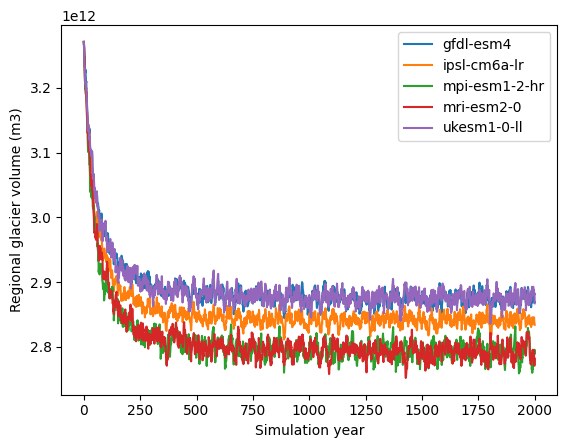

In [8]:
for gcm in ds_sel.gcm:
    plt.plot(ds_sel.simulation_year, ds_sel.sel(gcm=gcm).volume_m3, '-', label=gcm.values)
plt.ylabel('Regional glacier volume (m3)')
plt.xlabel('Simulation year')
plt.legend(loc='upper right');

# 2. I want to analyse the relationship of steady-state mass changes of a glacier model to global warming for a specific region

we can also compare all experiments of the Kraaijenbrink model by looking into the warming of these experiments:

In [9]:
# let's first get the data that links experiments to warming
pd_temp = pd.read_csv('climate_input_data/temp_ch_ipcc_ar6_isimip3b.csv', index_col=[0])

In [10]:
# we need this to later assign the coordinates to the glacier volume change dataset
pd_temp = pd_temp.set_index(['gcm', 'period_scenario'])

In [11]:
# create a "experiments" variable out of gcm and period_scenario
ds_stack = ds.stack(experiments=['gcm','period_scenario'])


In [12]:
# let's assign the coordinates by making sure that we use the correct experiment order
ds_stack = ds_stack.assign_coords(temp_ch_ipcc = ('experiments',
                                                   pd_temp.loc[ds_stack.experiments,'temp_ch_ipcc']))

In [13]:
# now we have assigned a global warming for every of the 80 experiments
ds_stack.experiments

<xarray.DataArray 'experiments' (experiments: 80)>
array([('gfdl-esm4', '1851-1870_hist'), ('gfdl-esm4', '1901-1920_hist'),
       ('gfdl-esm4', '1951-1970_hist'), ('gfdl-esm4', '1995-2014_hist'),
       ('gfdl-esm4', '2021-2040_ssp126'), ('gfdl-esm4', '2021-2040_ssp370'),
       ('gfdl-esm4', '2021-2040_ssp585'), ('gfdl-esm4', '2041-2060_ssp126'),
       ('gfdl-esm4', '2041-2060_ssp370'), ('gfdl-esm4', '2041-2060_ssp585'),
       ('gfdl-esm4', '2061-2080_ssp126'), ('gfdl-esm4', '2061-2080_ssp370'),
       ('gfdl-esm4', '2061-2080_ssp585'), ('gfdl-esm4', '2081-2100_ssp126'),
       ('gfdl-esm4', '2081-2100_ssp370'), ('gfdl-esm4', '2081-2100_ssp585'),
       ('ipsl-cm6a-lr', '1851-1870_hist'), ('ipsl-cm6a-lr', '1901-1920_hist'),
       ('ipsl-cm6a-lr', '1951-1970_hist'), ('ipsl-cm6a-lr', '1995-2014_hist'),
       ('ipsl-cm6a-lr', '2021-2040_ssp126'),
       ('ipsl-cm6a-lr', '2021-2040_ssp370'),
       ('ipsl-cm6a-lr', '2021-2040_ssp585'),
       ('ipsl-cm6a-lr', '2041-2060_ssp126'),
       ('ipsl-cm6a-lr', '2041-2060_ssp370'),
       ('ipsl-cm6a-lr', '2041-2060_ssp585'),
       ('ipsl-cm6a-lr', '2061-2080_ssp126'),
       ('ipsl-cm6a-lr', '2061-2080_ssp370'),
       ('ipsl-cm6a-lr', '2061-2080_ssp585'),
       ('ipsl-cm6a-lr', '2081-2100_ssp126'),
       ('ipsl-cm6a-lr', '2081-2100_ssp370'),
       ('ipsl-cm6a-lr', '2081-2100_ssp585'),
       ('mpi-esm1-2-hr', '1851-1870_hist'),
       ('mpi-esm1-2-hr', '1901-1920_hist'),
       ('mpi-esm1-2-hr', '1951-1970_hist'),
       ('mpi-esm1-2-hr', '1995-2014_hist'),
       ('mpi-esm1-2-hr', '2021-2040_ssp126'),
       ('mpi-esm1-2-hr', '2021-2040_ssp370'),
       ('mpi-esm1-2-hr', '2021-2040_ssp585'),
       ('mpi-esm1-2-hr', '2041-2060_ssp126'),
       ('mpi-esm1-2-hr', '2041-2060_ssp370'),
       ('mpi-esm1-2-hr', '2041-2060_ssp585'),
       ('mpi-esm1-2-hr', '2061-2080_ssp126'),
       ('mpi-esm1-2-hr', '2061-2080_ssp370'),
       ('mpi-esm1-2-hr', '2061-2080_ssp585'),
       ('mpi-esm1-2-hr', '2081-2100_ssp126'),
       ('mpi-esm1-2-hr', '2081-2100_ssp370'),
       ('mpi-esm1-2-hr', '2081-2100_ssp585'), ('mri-esm2-0', '1851-1870_hist'),
       ('mri-esm2-0', '1901-1920_hist'), ('mri-esm2-0', '1951-1970_hist'),
       ('mri-esm2-0', '1995-2014_hist'), ('mri-esm2-0', '2021-2040_ssp126'),
       ('mri-esm2-0', '2021-2040_ssp370'), ('mri-esm2-0', '2021-2040_ssp585'),
       ('mri-esm2-0', '2041-2060_ssp126'), ('mri-esm2-0', '2041-2060_ssp370'),
       ('mri-esm2-0', '2041-2060_ssp585'), ('mri-esm2-0', '2061-2080_ssp126'),
       ('mri-esm2-0', '2061-2080_ssp370'), ('mri-esm2-0', '2061-2080_ssp585'),
       ('mri-esm2-0', '2081-2100_ssp126'), ('mri-esm2-0', '2081-2100_ssp370'),
       ('mri-esm2-0', '2081-2100_ssp585'), ('ukesm1-0-ll', '1851-1870_hist'),
       ('ukesm1-0-ll', '1901-1920_hist'), ('ukesm1-0-ll', '1951-1970_hist'),
       ('ukesm1-0-ll', '1995-2014_hist'), ('ukesm1-0-ll', '2021-2040_ssp126'),
       ('ukesm1-0-ll', '2021-2040_ssp370'),
       ('ukesm1-0-ll', '2021-2040_ssp585'),
       ('ukesm1-0-ll', '2041-2060_ssp126'),
       ('ukesm1-0-ll', '2041-2060_ssp370'),
       ('ukesm1-0-ll', '2041-2060_ssp585'),
       ('ukesm1-0-ll', '2061-2080_ssp126'),
       ('ukesm1-0-ll', '2061-2080_ssp370'),
       ('ukesm1-0-ll', '2061-2080_ssp585'),
       ('ukesm1-0-ll', '2081-2100_ssp126'),
       ('ukesm1-0-ll', '2081-2100_ssp370'),
       ('ukesm1-0-ll', '2081-2100_ssp585')], dtype=object)
Coordinates:
  * experiments      (experiments) object MultiIndex
  * gcm              (experiments) <U13 'gfdl-esm4' ... 'ukesm1-0-ll'
  * period_scenario  (experiments) <U16 '1851-1870_hist' ... '2081-2100_ssp585'
    temp_ch_ipcc     (experiments) float64 0.2314 0.4783 0.3923 ... 5.84 6.884

In [14]:
# let's select the same model and rgi_reg as before, but let's now look into all experiments... 
ds_stack_sel = ds_stack.sel(model_author=model_author).sel(rgi_reg=rgi_reg)
ds_stack_sel

<xarray.Dataset>
Dimensions:          (simulation_year: 5001, experiments: 80)
Coordinates:
    model_author     <U14 'Kraaijenbrink'
  * simulation_year  (simulation_year) int16 0 1 2 3 4 ... 4997 4998 4999 5000
    rgi_reg          <U2 '13'
  * experiments      (experiments) object MultiIndex
  * gcm              (experiments) <U13 'gfdl-esm4' ... 'ukesm1-0-ll'
  * period_scenario  (experiments) <U16 '1851-1870_hist' ... '2081-2100_ssp585'
    temp_ch_ipcc     (experiments) float64 0.2314 0.4783 0.3923 ... 5.84 6.884
Data variables:
    volume_m3        (simulation_year, experiments) float32 3.271e+12 ... nan
    area_m2          (simulation_year, experiments) float32 4.93e+10 ... nan

In [15]:
# let's just use the average over the last 100 years, here the simulations only go for 2000 years
ds_stack_sel_steady_state = ds_stack_sel.sel(simulation_year=slice(1900,2000)).mean(dim='simulation_year')

Text(0.5, 0, 'Global mean temperature above pre-industrial (°C)')

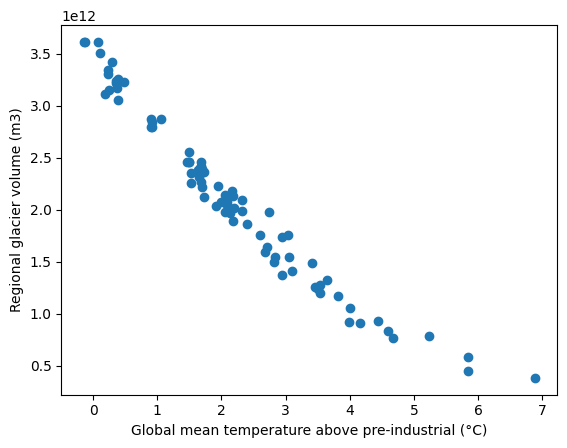

In [60]:
plt.plot(ds_stack_sel_steady_state.temp_ch_ipcc, ds_stack_sel_steady_state.volume_m3, 'o')
plt.ylabel('Regional glacier volume (m3)')
plt.xlabel('Global mean temperature above pre-industrial (°C)')

- IMPORTANT: we used now the raw data without any postprocessing


The actual visualisations and analysis in the manuscript is done with this postprocessed variant of the dataset: `GMIP3_reg_glacier_model_data/all_shifted_glacierMIP3_Feb12_2024_models_all_rgi_regions_sum_scaled_extended_repeat_last_101yrs_via_5yravg.nc` where the data got scaled to always match at the start Farinotti et al. 2021, then extended to always go until the year 5000 and then shifted to start at a timepoint that is near to the 2020 regional glacier mass states (see methods)

Let's look instead into the shifted data:

In [19]:
ds_shifted = xr.open_dataset('GMIP3_reg_glacier_model_data/all_shifted_glacierMIP3_Feb12_2024_models_all_rgi_regions_sum_scaled_extended_repeat_last_101yrs_via_5yravg.nc')

In [20]:
ds_shifted


<xarray.Dataset>
Dimensions:                           (model_author: 8, year_after_2020: 5051,
                                       period_scenario: 16, gcm: 5, rgi_reg: 19)
Coordinates:
  * model_author                      (model_author) <U14 'CISM2' ... 'PyGEM-...
  * year_after_2020                   (year_after_2020) float32 -50.0 ... 5e+03
  * period_scenario                   (period_scenario) <U16 '1851-1870_hist'...
  * gcm                               (gcm) <U13 'gfdl-esm4' ... 'ukesm1-0-ll'
  * rgi_reg                           (rgi_reg) <U2 '01' '02' '03' ... '18' '19'
Data variables:
    simulation_year                   (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...
    temp_ch_ipcc                      (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...
    yrs_w_most_similar_state_to_2020  (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float32 ...
    volume_rel_2020_%                 (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...
    volume_m3                         (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...

- the postprocessed file only has the eight glacier models used for the first manuscript
- for the analysis we only use the relative values (i.e. `volume_rel_2020`) together with the new timeseries (`year_after_2020`)

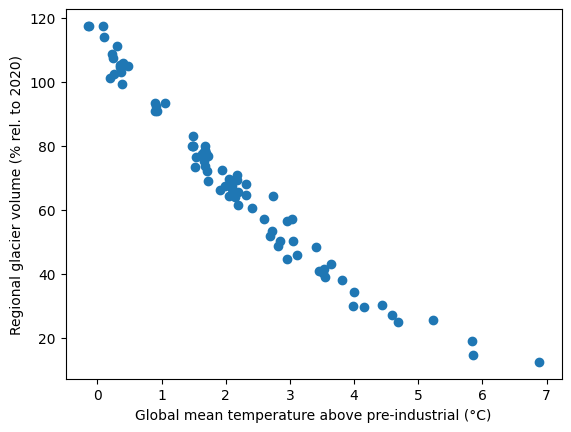

In [25]:
# we repeat the same as above:
ds_stack_shifted = ds_shifted.stack(experiments=['gcm','period_scenario'])
ds_stack_shifted = ds_stack_shifted.assign_coords(temp_ch_ipcc = ('experiments',
                                                   pd_temp.loc[ds_stack.experiments,'temp_ch_ipcc']))
ds_stack_sel_shifted = ds_stack_shifted.sel(model_author=model_author).sel(rgi_reg=rgi_reg)
# but here we use now the `year_after_2020` coordinate
ds_stack_sel_steady_state_shifted = ds_stack_sel_shifted.sel(year_after_2020=slice(1900,2000)).mean(dim='year_after_2020')


plt.plot(ds_stack_sel_steady_state_shifted.temp_ch_ipcc, ds_stack_sel_steady_state_shifted['volume_rel_2020_%'], 'o')
plt.ylabel('Regional glacier volume (% rel. to 2020)')
plt.xlabel('Global mean temperature above pre-industrial (°C)');

## 3. I want to extract LOWESS fitted steady-state glacier mass estimates

In [62]:
# lets load the most used lowess fit variant: fit uses relative remaining mass at 
# steady-state (101-year rolling average of the last simulation years)
# together with global mean warming above preindustrial
pd_lowess = pd.read_csv('lowess_fit_rel_2020_101yr_avg_steady_state_Feb12_2024.csv', index_col=[0])

In [64]:
pd_lowess_reg =pd_lowess.loc[pd_lowess.region==rgi_reg]

- we can for example extract values not available  from the Extended Data Table 1:

In [71]:
# regional lowess fit estimates at 2.2°C for that region
pd_lowess_reg.loc[pd_lowess_reg.temp_ch==2.2]

temp_ch       0.05       0.17       0.25       0.5       0.75  \
1726      2.2  18.448355  22.158413  24.513387  35.15934  59.677833   

           0.83      0.95  frac region  year  it    N  
1726  63.699423  69.69257  0.21     13  5000   2  500

- or show the entire fit by also showing another distribution range of the fitted model spread:

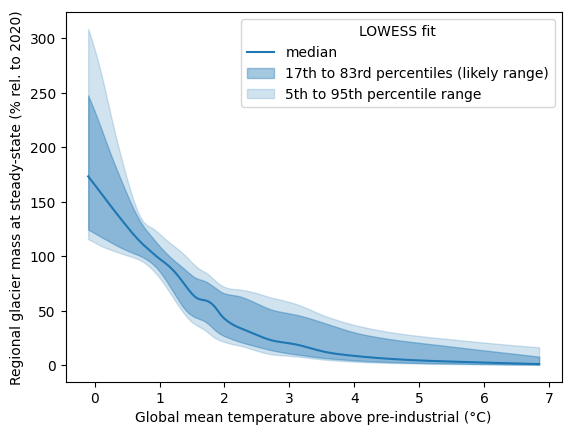

In [81]:
sns.lineplot(data=pd_lowess_reg, x='temp_ch', y='0.5', label='median', color='C0')
plt.fill_between(pd_lowess_reg.temp_ch, pd_lowess_reg['0.17'], pd_lowess_reg['0.83'], alpha=0.4,
                label = '17th to 83rd percentiles (likely range)', color='C0')
plt.fill_between(pd_lowess_reg.temp_ch, pd_lowess_reg['0.05'], pd_lowess_reg['0.95'], alpha=0.2,
                label = '5th to 95th percentile range', color='C0')

# note that regional relative glacier volume and mass are the same
plt.ylabel('Regional glacier mass at steady-state (% rel. to 2020)')
plt.xlabel('Global mean temperature above pre-industrial (°C)')
plt.legend(title='LOWESS fit');